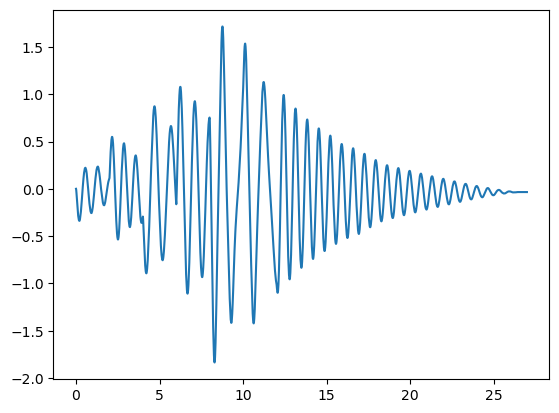

In [39]:
from numpy import zeros, size
from matplotlib.pyplot import plot
from ament_index_python.packages import get_package_share_directory
import os

oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_signal_response.csv",
)

f = open(oscillations_file, "r")
lines = f.readlines()
numlines = size(lines)
f.close()

# x_rosbag = zeros(numlines - 1)
# t_rosbag = zeros(numlines - 1)

x_rosbag = []
t_rosbag = []

x0_vel_rosbag = []
x1_pos_rosbag = []

start_idx = 5060
t_offset = float(lines[start_idx].split(",")[0])
x_offset = 0.0

x1_pos_offset = float(lines[start_idx].split(",")[23])


for i in range(start_idx, numlines):
    vals = lines[i].split(",")
    if vals[21] != '':
        t_rosbag.append(float(vals[0]) - t_offset)
        x_rosbag.append(float(vals[24]) - x_offset)
        x0_vel_rosbag.append(float(vals[21]) - x_offset)
        x1_pos_rosbag.append(float(vals[23]) - x1_pos_offset)

        if t_rosbag[-1] > 27.0:
            break

plot(t_rosbag, x1_pos_rosbag)


In [40]:
import yaml
import os
from ament_index_python.packages import get_package_share_directory

pendulum_params_file = os.path.join(
    get_package_share_directory("furuta_pendulum_description"),
    "config",
    "pendulum_parameters.yaml",
)

with open(pendulum_params_file, "r") as file:
    pendulum_params = yaml.safe_load(file)["/**"]["ros__parameters"]

g = 9.80665

m1 = pendulum_params["m1"]
m2 = pendulum_params["m2"]

l1 = pendulum_params["l1"]
l2 = pendulum_params["l2"]

L1 = pendulum_params["L1"]
L2 = pendulum_params["L2"]

J1 = pendulum_params["J1"]
J2 = pendulum_params["J2"]

b1 = pendulum_params["b1"]
b2 = pendulum_params["b2"]
# initially b2 wasn't correct, this is initial guess after initial optimization
# b2 = 0.00005
# b1 = 0.005

J2_hat = J2 + m2 * l2 * l2
J0_hat = J1 + m1 * l1 * l1 + m2 * L1 * L1

tau1 = 0.1433
tau2 = 0.0

MAX_MOTOR_VEL = 22.0
MAX_MOTOR_VEL_SCALE_POS = 3.85
MAX_MOTOR_VEL_SCALE_NEG = 3.25
# tau1_scale = 1.0/3.8349449703585776
# tau1_scale = 1.0/17.2
tau1_scale = 1.0

# Optimization

In [41]:
import numpy as np
from scipy.integrate import odeint


class F_opt:
    def __init__(
        self,
        m1,
        m2,
        l1,
        l2,
        L1,
        L2,
        J1,
        J2,
        b1,
        b2,
        tau1_scale_1,
        tau1_scale_2,
        tau1_scale_3,
    ):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.L1 = L1
        self.L2 = L2
        self.J1 = J1
        self.J2 = J2
        self.b1 = b1
        self.b2 = b2
        self.J2_hat = J2 + m2 * l2 * l2
        self.J0_hat = J1 + m1 * l1 * l1 + m2 * L1 * L1

        self.tau1_scale = tau1_scale_1
        self.tau1 = [
            (0.1 * tau1_scale_1, 2.0),
            (-0.1 * tau1_scale_1, 4.0),
            (0.2 * tau1_scale_2, 6.0),
            (-0.2 * tau1_scale_2, 8.0),
            (0.3 * tau1_scale_3, 10.0),
            (-0.3 * tau1_scale_3, 12.0),
            (0.0, 27.0),
        ]
        self.tau1_idx = 0

    def __call__(self, t, y):
        # based on https://www.hindawi.com/journals/jcse/2011/528341/

        # theta3 = dtheta1
        # theta4 = dtheta2
        # dtheta3 = ddtheta1
        # dtheta4 = ddtheta2

        # theta1 = y[0]
        theta2 = y[1]
        theta3 = y[2]
        theta4 = y[3]

        # if theta3 > MAX_MOTOR_VEL:
        #     theta3 = MAX_MOTOR_VEL

        if t > self.tau1[self.tau1_idx][1] and self.tau1_idx < len(self.tau1) - 1:
            self.tau1_idx += 1

        vec11 = np.zeros((5, 1))
        vec11[0] = -self.J2_hat * self.b1
        vec11[1] = self.m2 * self.L1 * self.l2 * np.cos(theta2) * self.b2
        vec11[2] = -np.power(self.J2_hat, 2) * np.sin(2.0 * theta2)
        vec11[3] = (
            -0.5
            * self.J2_hat
            * self.m2
            * self.L1
            * self.l2
            * np.cos(theta2)
            * np.sin(2.0 * theta2)
        )
        vec11[4] = self.J2_hat * self.m2 * self.L1 * self.l2 * np.sin(theta2)

        vec21 = np.zeros((5, 1))
        vec21[0] = self.m2 * self.L1 * self.l2 * np.cos(theta2) * self.b1
        vec21[1] = -self.b2 * (self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2))
        vec21[2] = (
            self.m2
            * self.L1
            * self.l2
            * self.J2_hat
            * np.cos(theta2)
            * np.sin(2.0 * theta2)
        )
        vec21[3] = (
            -0.5
            * np.sin(2.0 * theta2)
            * (self.J0_hat * self.J2_hat + np.power(self.J2_hat * np.sin(theta2), 2))
        )
        vec21[4] = (
            -0.5 * np.power(self.m2 * self.L1 * self.l2, 2) * np.sin(2.0 * theta2)
        )

        thetas_vec = np.zeros((5, 1))
        thetas_vec[0] = theta3
        thetas_vec[1] = theta4
        thetas_vec[2] = theta3 * theta4
        thetas_vec[3] = np.power(theta3, 2)
        thetas_vec[4] = np.power(theta4, 2)

        vec12 = np.zeros((3, 1))
        vec12[0] = self.J2_hat
        vec12[1] = -self.m2 * self.L1 * self.l2 * np.cos(theta2)
        vec12[2] = 0.5 * np.power(self.m2 * self.l2, 2) * self.L1 * np.sin(2.0 * theta2)

        vec22 = np.zeros((3, 1))
        vec22[0] = -self.m2 * self.L1 * self.l2 * np.cos(theta2)
        vec22[1] = self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2)
        vec22[2] = (
            -self.m2
            * self.l2
            * np.sin(theta2)
            * (self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2))
        )

        Kv = 80.0
        Kemf = 9.549304651/Kv
        Kt = 8.27 / Kv
        R = 17.2

        tau1 = (Kt / R) * (self.tau1[self.tau1_idx][0] / Kt - Kemf * theta3)

        taus_g_vec = np.zeros((3, 1))
        taus_g_vec[0] = tau1
        taus_g_vec[1] = tau2
        taus_g_vec[2] = g

        denominator = (
            self.J0_hat * self.J2_hat
            + np.power(self.J2_hat * np.sin(theta2), 2)
            - np.power(self.m2 * self.L1 * self.l2 * np.cos(theta2), 2)
        )

        numerator1 = (vec11.T @ thetas_vec + vec12.T @ taus_g_vec)[0]
        numerator2 = (vec21.T @ thetas_vec + vec22.T @ taus_g_vec)[0]

        # max_vel_calculated = np.fabs(MAX_MOTOR_VEL_SCALE * 10.0 * self.tau1[self.tau1_idx][0] / self.tau1_scale)
        if self.tau1[self.tau1_idx][0] > 0.0:
            max_vel_calculated = (
                MAX_MOTOR_VEL_SCALE_POS
                * 10.0
                * self.tau1[self.tau1_idx][0]
                / self.tau1_scale
            )
        else:
            max_vel_calculated = (
                MAX_MOTOR_VEL_SCALE_NEG
                * 10.0
                * self.tau1[self.tau1_idx][0]
                / self.tau1_scale
            )

        dy = np.zeros(4)
        dy[0] = theta3
        dy[1] = theta4
        dy[2] = numerator1 / denominator
        dy[3] = numerator2 / denominator

        # if theta3 > max_vel_calculated and dy[2] > 0.0:
        #     dy[0] = max_vel_calculated
        #     dy[2] = 0.0
        # elif theta3 < -max_vel_calculated and dy[2] < 0.0:
        #     dy[0] = -max_vel_calculated
        #     dy[2] = 0.0

        if max_vel_calculated > 0.0 and theta3 > max_vel_calculated and dy[2] > 0.0:
            dy[0] = max_vel_calculated
            dy[2] = 0.0
        elif max_vel_calculated < 0.0 and theta3 < max_vel_calculated and dy[2] < 0.0:
            dy[0] = max_vel_calculated
            dy[2] = 0.0

        return dy


# def create_trajectory(t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale):
#     f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale)
#     s = odeint(f_opt, y0=[0, 0.0, 0, 0], t=t)
#     return [x[3] for x in s]

# def create_trajectory(t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1):
#     f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1)

#     s = []
#     s.append([0, 0.0, 0, 0])
#     for id in range(0, len(t) - 1):
#         s.append(odeint(f_opt, y0=s[-1], t=[t[id], t[id+1]])[-1])

#     return [x[3] for x in s]

from scipy.integrate import solve_ivp

# def create_trajectory_joint0(t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1):
#     f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1)

#     s = []
#     s.append([0, 0.0, 0, 0])
#     for id in range(0, len(t) - 1):
#         s.append(odeint(f_opt, y0=s[-1], t=[t[id], t[id+1]])[-1])

#     return [x[2] for x in s]

# def create_trajectory_joint0(t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1):
#     f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1)

#     s = []
#     s.append([0, 0.0, 0, 0])
#     for id in range(0, len(t) - 1):
#         # s.append(solve_ivp(f_opt, t_span=[t[id], t[id+1]], y0 = s[-1]).y_events[-1][0])
#         y = (solve_ivp(f_opt, t_span=[t[id], t[id+1]], y0 = s[-1]).y)
#         s.append([y[0][-1], y[1][-1], y[2][-1], y[3][-1]])

#     return [x[2] for x in s]


def create_trajectory(t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1, tau2, tau3):
    f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1, tau2, tau3)
    s = solve_ivp(f_opt, t_span=[t[0], t[-1]], y0=[0, 0.0, 0, 0], t_eval=t).y
    return s[3]


def create_trajectory_joint0(
    t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1, tau2, tau3
):
    f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1, tau2, tau3)
    s = solve_ivp(f_opt, t_span=[t[0], t[-1]], y0=[0, 0.0, 0, 0], t_eval=t).y
    return s[2]


def create_trajectory_joint1_pos(
    t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1, tau2, tau3
):
    f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1, tau2, tau3)
    s = solve_ivp(f_opt, t_span=[t[0], t[-1]], y0=[0, 0.0, 0, 0], t_eval=t).y
    return s[1]

/tmp/ipykernel_222139/69727009.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[2] = numerator1 / denominator
/tmp/ipykernel_222139/69727009.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[3] = numerator2 / denominator


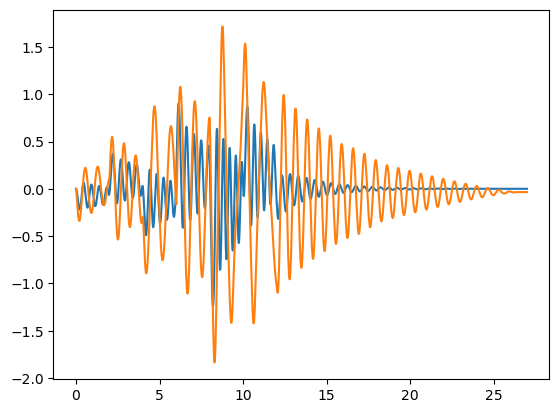

In [42]:
plot(t_rosbag, create_trajectory_joint1_pos(t_rosbag, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale, tau1_scale, tau1_scale]))
plot(t_rosbag, x1_pos_rosbag)

/tmp/ipykernel_222139/69727009.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[2] = numerator1 / denominator
/tmp/ipykernel_222139/69727009.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[3] = numerator2 / denominator


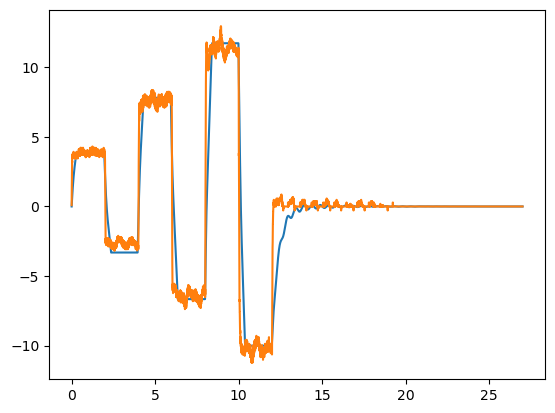

In [43]:
plot(t_rosbag, create_trajectory_joint0(t_rosbag, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale, tau1_scale, tau1_scale]))
# plot(create_trajectory_joint0(t_rosbag, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale]))
plot(t_rosbag, x0_vel_rosbag)

/tmp/ipykernel_222139/69727009.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[2] = numerator1 / denominator
/tmp/ipykernel_222139/69727009.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[3] = numerator2 / denominator


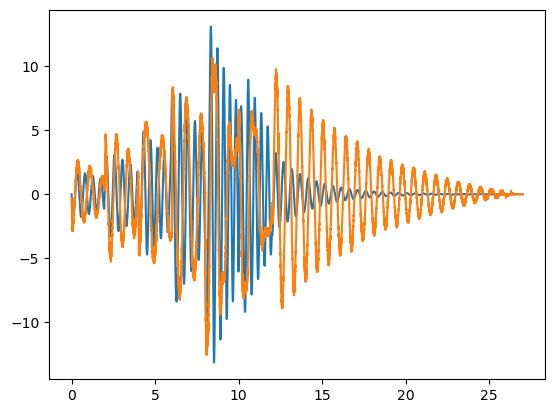

In [44]:
plot(t_rosbag, create_trajectory(t_rosbag, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale, tau1_scale, tau1_scale]))
plot(t_rosbag, x_rosbag)


In [600]:
from scipy.optimize import curve_fit

# b1 can't be 0 - bounds won't be correct, so set it to really low value
# b1 = 0.1

min_scale = 0.01
max_scale = 100.0
min_bounds = [
    0.8 * m1,
    0.8 * m2,
    0.8 * l1,
    0.8 * l2,
    0.8 * L1,
    0.8 * L2,
    0.8 * J1,
    0.8 * J2,
    min_scale * b1,
    min_scale * b2,
    min_scale * tau1_scale,
    min_scale * tau1_scale,
    min_scale * tau1_scale,
]
max_bounds = [
    1.2 * m1,
    1.2 * m2,
    1.2 * l1,
    1.2 * l2,
    1.2 * L1,
    1.2 * L2,
    1.2 * J1,
    1.2 * J2,
    max_scale * b1,
    max_scale * b2,
    max_scale * tau1_scale,
    max_scale * tau1_scale,
    max_scale * tau1_scale,
]

initial_guess = [m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale, tau1_scale, tau1_scale]

# opt_params, _ = curve_fit(
#     create_trajectory,
#     t_rosbag,
#     x_rosbag,
#     p0=initial_guess,
#     bounds=(min_bounds, max_bounds),
# )

opt_params, _ = curve_fit(
    create_trajectory_joint1_pos,
    t_rosbag,
    x1_pos_rosbag,
    p0=initial_guess,
    bounds=(min_bounds, max_bounds),
)


<BarContainer object of 13 artists>

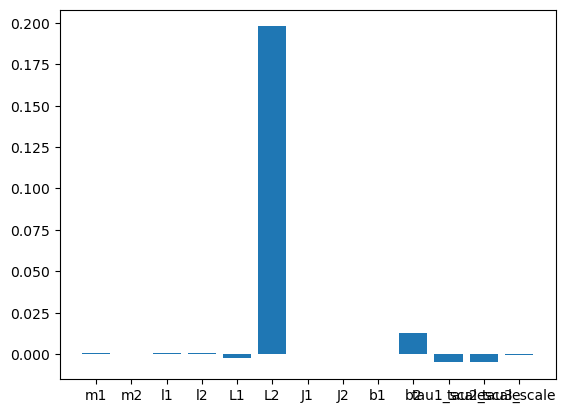

In [601]:
from matplotlib.pyplot import bar

bar(
    ["m1", "m2", "l1", "l2", "L1", "L2", "J1", "J2", "b1", "b2", "tau1_scale", "tau2_scale", "tau3_scale"],
    (opt_params - initial_guess) / initial_guess,
)


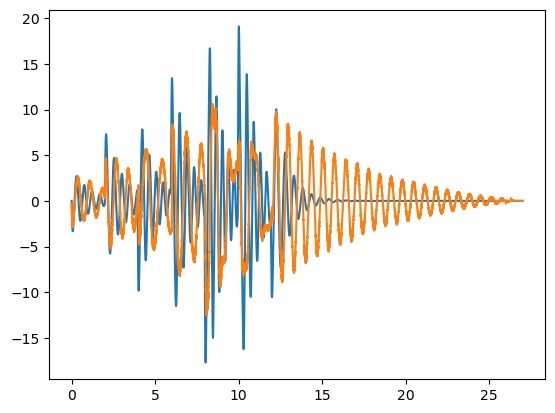

In [602]:
plot(t_rosbag, create_trajectory(t_rosbag, *opt_params))
plot(t_rosbag, x_rosbag)


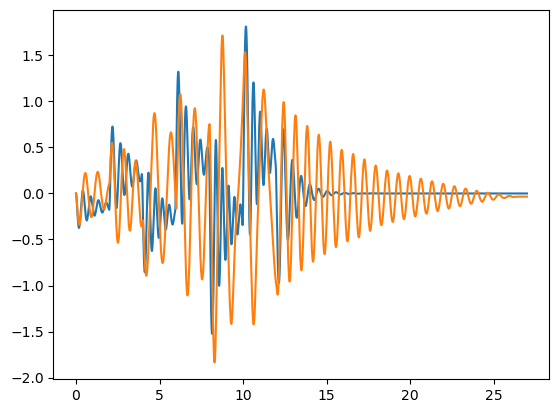

In [603]:
plot(t_rosbag, create_trajectory_joint1_pos(t_rosbag, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, tau1_scale, tau1_scale, tau1_scale]))
plot(t_rosbag, x1_pos_rosbag)

In [604]:
print(f"m1: {opt_params[0]}")
print(f"m2: {opt_params[1]}")
print(f"l1: {opt_params[2]}")
print(f"l2: {opt_params[3]}")
print(f"L1: {opt_params[4]}")
print(f"L2: {opt_params[5]}")
print(f"J1: {opt_params[6]}")
print(f"J2: {opt_params[7]}")
print(f"b1: {opt_params[8]}")
print(f"b2: {opt_params[9]}")
print(f"tau1: {opt_params[10]}")


m1: 0.04954182606327629
m2: 0.00829575297105582
l1: 0.06480435943647181
l2: 0.058358631828735526
L1: 0.07930365529155461
L2: 0.11667534645000016
J1: 4.1302214110896695e-05
J2: 5.6278768199347955e-06
b1: 0.005000450917701057
b2: 5.0623217215186335e-05
tau1: 0.2595177370584204


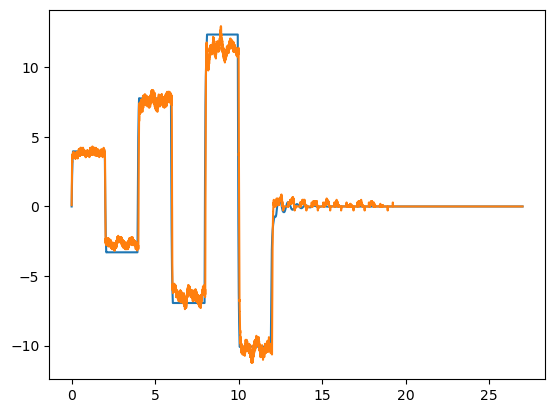

In [605]:


plot(t_rosbag, create_trajectory_joint0(t_rosbag, *opt_params))
plot(t_rosbag, x0_vel_rosbag)